In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers torch pillow scikit-learn

In [13]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from sklearn.decomposition import PCA
import numpy as np
import os
import pandas as pd
import io

In [7]:
# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "facebook/dinov2-small"  # 384 dim output, fast on T4
N_PCA_COMPONENTS = 5  # Number of covariates to feed into Chronos

In [5]:
base_dir = DATA_PATH = "/content/drive/MyDrive/FM_project/dataset"
train_path = os.path.join(base_dir, "skippd_train_aligned_v13_with_time_features.parquet")

In [12]:
# Add this temporary check before your loop
df = pd.read_parquet(train_path)
first_item = df["image"].iloc[0]
print(f"Data type: {type(first_item)}")
print(f"Keys: {first_item.keys() if isinstance(first_item, dict) else 'Not a dict'}")

Data type: <class 'dict'>
Keys: dict_keys(['bytes', 'path'])


In [19]:
def load_images(path):
    print(f"Loading {path}...")
    df = pd.read_parquet(path)

    # Iterate through the first 20 rows
    images = []
    for i, item in enumerate(df["image"].head(20)):
        try:
            # 1. Extract the raw bytes from the dictionary
            img_bytes = item['bytes']

            # 2. Convert bytes to a file-like object and open with PIL
            img = Image.open(io.BytesIO(img_bytes))
            images.append(img)

            # 3. Save locally
            #img.save(f"{i}.jpg")

        except Exception as e:
            print(f"Failed to load image {i}: {e}")

    return images

    print(f"Successfully saved {len(images)} images.")


In [15]:
load_images(train_path)

Loading /content/drive/MyDrive/FM_project/dataset/skippd_train_aligned_v13_with_time_features.parquet...
Successfully saved 20 images.


In [17]:
class SkyFeatureExtractor:
    def __init__(self, model_name=MODEL_NAME, device=DEVICE):
        print(f"Loading {model_name} on {device}...")
        self.device = device
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval() # Set to evaluation mode

    def extract_features_batch(self, images):
        """
        Expects a list of PIL Images.
        Returns a numpy array of shape (batch_size, 384)
        """
        # Preprocess images (Resize, Normalize)
        inputs = self.processor(images=images, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)

        # DINOv2 uses the [CLS] token (first token) as the global image representation
        # Shape: [batch_size, sequence_length, hidden_size] -> We take index 0
        last_hidden_states = outputs.last_hidden_state
        cls_token = last_hidden_states[:, 0, :]

        return cls_token.cpu().numpy()

In [20]:
# --- Simulation of your Workflow ---

# 1. Setup the Extractor
extractor = SkyFeatureExtractor()

# 2. Create Dummy Data (Replace this with your real image loading loop)
# In reality: images = [Image.open(path) for path in image_paths]
print("Generating dummy sky images...")
#dummy_images = [Image.new('RGB', (224, 224), color=(i*10, 100, 200)) for i in range(20)] # 20 fake images
images=load_images(train_path)
# 3. Extract Raw Features (High Dimensionality: 384)
print("Extracting features from images...")
# Note: For large datasets, do this in batches (e.g., batch_size=32)
raw_features = extractor.extract_features_batch(images)
print(f"Raw Feature Shape: {raw_features.shape}") # (20, 384)

# 4. Dimensionality Reduction (PCA)
# CRITICAL: Fit PCA on your TRAINING set only, then apply to validation/test.
print(f"Reducing dimensions to {N_PCA_COMPONENTS} components...")
pca = PCA(n_components=N_PCA_COMPONENTS)
compact_covariates = pca.fit_transform(raw_features)

print("-" * 30)
print(f"Final Covariates Shape: {compact_covariates.shape}") # (20, 5)
print("First row of covariates (ready for Chronos):")
print(compact_covariates)

# 5. Saving for Chronos
# You would now attach these 5 columns to your DataFrame alongside the timestamp
# df['sky_feature_1'] = compact_covariates[:, 0]
# df['sky_feature_2'] = compact_covariates[:, 1]
# ...

Loading facebook/dinov2-small on cuda...
Generating dummy sky images...
Loading /content/drive/MyDrive/FM_project/dataset/skippd_train_aligned_v13_with_time_features.parquet...
Extracting features from images...
Raw Feature Shape: (20, 384)
Reducing dimensions to 5 components...
------------------------------
Final Covariates Shape: (20, 5)
First row of covariates (ready for Chronos):
[[ 46.748154    24.864492    -2.3665953    0.1422857   -0.406448  ]
 [  4.671502    -8.699795     9.8491125  -16.121147     0.97643983]
 [  9.046513   -19.242579     3.0791945   -2.984059    -0.9070744 ]
 [  7.266932   -18.035112    -0.65396667   1.8427058   -3.379051  ]
 [  6.6997595  -16.015295     1.367246     1.942406    -0.3595972 ]
 [  3.0556986   -9.826038     0.38365668   3.0340376   12.001091  ]
 [  4.056365   -14.551491    -4.8669677    5.7596183   -1.04583   ]
 [  2.3907814  -11.424883    -5.5735       6.3692474   -1.5179931 ]
 [ -3.036337    -4.5436707   -6.949097    -0.45776916  -0.19404826]


Loading facebook/dinov2-small on cuda...
Processing 50 images...


100%|██████████| 50/50 [00:00<00:00, 145.16it/s]


Raw Features Shape: (50, 384)
Standardizing features...
Fitting PCA with 10 components...
Explained Variance by 10 components: 96.21%


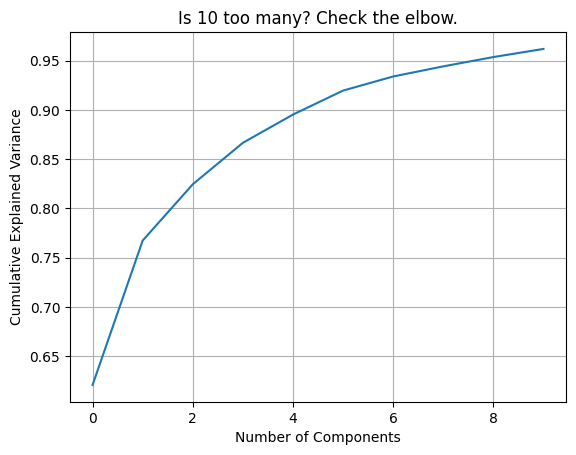

✅ Explained Variance: 96.21%
Final Shape for Chronos: (50, 10)


In [22]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import pandas as pd
import io
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm # Progress bar

# --- Configuration ---
MODEL_NAME = "facebook/dinov2-small" # Example (Using small for speed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # Process 32 images at a time to save VRAM
N_PCA_COMPONENTS = 10 # Chronos can handle 10-15 covariates easily

class SkyFeatureExtractor:
    def __init__(self, model_name=MODEL_NAME, device=DEVICE):
        print(f"Loading {model_name} on {device}...")
        self.device = device
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

    def extract_features(self, images):
        """
        Process a list of images in one batch (helper function).
        """
        if not images:
            return np.array([])

        # DINOv2 preprocessing
        inputs = self.processor(images=images, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)

        # Extract CLS token (global image representation)
        # Shape: [batch, sequence_len, hidden_size] -> [batch, hidden_size]
        last_hidden_states = outputs.last_hidden_state
        cls_token = last_hidden_states[:, 0, :]

        return cls_token.cpu().numpy()

def process_dataset_in_batches(parquet_path, extractor, batch_size=32, limit=None):
    """
    Reads parquet, extracts bytes, and runs inference in batches to save RAM.
    """
    df = pd.read_parquet(parquet_path)

    if limit:
        df = df.head(limit)

    all_features = []
    batch_images = []

    print(f"Processing {len(df)} images...")

    for i, raw_data in tqdm(enumerate(df["image"]), total=len(df)):
        try:
            # 1. Byte extraction (The fix from before)
            if isinstance(raw_data, dict):
                img_bytes = raw_data.get('bytes')
                if img_bytes:
                    img = Image.open(io.BytesIO(img_bytes)).convert("RGB") # Ensure RGB
                    batch_images.append(img)
            elif isinstance(raw_data, bytes):
                img = Image.open(io.BytesIO(raw_data)).convert("RGB")
                batch_images.append(img)

            # 2. When batch is full, run inference
            if len(batch_images) >= batch_size:
                features = extractor.extract_features(batch_images)
                all_features.append(features)
                batch_images = [] # Clear memory

        except Exception as e:
            print(f"Skipping bad image at index {i}: {e}")

    # Process remaining images in the last batch
    if batch_images:
        features = extractor.extract_features(batch_images)
        all_features.append(features)

    # Stack all batches into one large numpy array
    return np.vstack(all_features)

# --- Workflow ---

# 1. Init Extractor
extractor = SkyFeatureExtractor()

# 2. Extract RAW Features (The heavy lifting)
# Using 'limit=50' for testing, remove 'limit' to run full dataset
raw_features = process_dataset_in_batches(train_path, extractor, batch_size=BATCH_SIZE, limit=50)

print(f"Raw Features Shape: {raw_features.shape}") # Should be (N, 384)

# 3. Standardization (Crucial for PCA)
print("Standardizing features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(raw_features)

# 4. PCA with Explained Variance Check
print(f"Fitting PCA with {N_PCA_COMPONENTS} components...")
pca = PCA(n_components=N_PCA_COMPONENTS)
compact_covariates = pca.fit_transform(features_scaled)

# SAFETY CHECK: Do these 10 features actually matter?
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Explained Variance by 10 components: {cumulative_variance[-1]:.2%}")

# Visualization of feature importance (Optional but recommended)
# This tells you if Feature 9 and 10 are actually useless noise
import matplotlib.pyplot as plt
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Is 10 too many? Check the elbow.')
plt.grid(True)
plt.show()

# Check quality
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"✅ Explained Variance: {explained_variance:.2%}")
if explained_variance < 0.70:
    print("⚠️ WARNING: Your PCA components capture less than 70% of the image info. Increase N_PCA_COMPONENTS.")

# 5. Result
print("Final Shape for Chronos:", compact_covariates.shape)

Loading facebook/dinov2-small on cuda...
Reading dataset from /content/drive/MyDrive/FM_project/dataset/skippd_train_aligned_v13_with_time_features.parquet...
Starting feature extraction...


Extracting Features: 100%|██████████| 18667/18667 [02:10<00:00, 143.03it/s]


Raw features extracted. Shape: (18667, 384)
Fitting Standard Scaler...
Fitting PCA (n=10)...
Explained Variance by 10 components: 84.12%


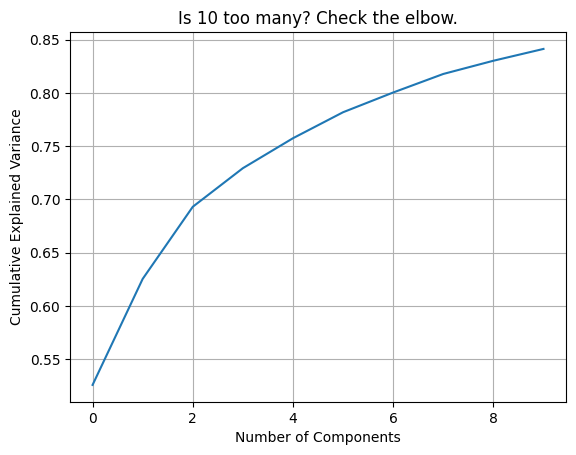

✅ Explained Variance: 84.12%
Merging new columns...
Saving new dataset to /content/drive/MyDrive/FM_project/dataset/skippd_train_aligned_v13_with_time_features_and_sky_features.parquet...
Done! 🎉
   sky_feature_0  sky_feature_1  sky_feature_2  sky_feature_3  sky_feature_4  \
0      15.121139      -0.276900      -0.062585       0.033653      -0.130343   
1     -12.327312      -2.774345      -3.020467       5.393642       0.480426   
2     -13.030835      -4.728989     -13.022429      10.897655       2.473341   
3     -12.786329      -6.514061      -9.707893      11.083717       5.290352   
4     -13.131073      -4.629575      -9.255823       9.302351       2.774514   

   sky_feature_5  sky_feature_6  sky_feature_7  sky_feature_8  sky_feature_9  
0      -0.007275      -0.039219       0.062125      -0.032554       0.043456  
1      -6.328221      11.478384       4.567176       4.990738      -3.433475  
2      -2.245973       5.450405       2.684266       0.526026      -0.563397  
3      

In [23]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import pandas as pd
import io
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# --- Configuration ---
BASE_DIR = "/content/drive/MyDrive/FM_project/dataset"
INPUT_PATH = os.path.join(BASE_DIR, "skippd_train_aligned_v13_with_time_features.parquet")
OUTPUT_PATH = os.path.join(BASE_DIR, "skippd_train_aligned_v13_with_time_features_and_sky_features.parquet")
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "feature_extractors") # To save PCA/Scaler

MODEL_NAME = "facebook/dinov2-small"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
N_COMPONENTS = 10

# Ensure save directory exists
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# --- 1. Define the Extractor Class ---
class SkyFeatureExtractor:
    def __init__(self, model_name=MODEL_NAME, device=DEVICE):
        print(f"Loading {model_name} on {device}...")
        self.device = device
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

    def extract_features(self, images):
        if not images: return np.array([])
        # Preprocess
        inputs = self.processor(images=images, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        # Get CLS token (index 0)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# --- 2. Processing Loop ---
def process_full_dataset(input_path, extractor, batch_size=32):
    print(f"Reading dataset from {input_path}...")
    df = pd.read_parquet(input_path)

    all_features = []
    batch_images = []

    print("Starting feature extraction...")
    # Iterate through the DataFrame
    for raw_data in tqdm(df["image"], desc="Extracting Features"):
        try:
            # Handle dictionary format (standard for this dataset)
            if isinstance(raw_data, dict):
                img_bytes = raw_data.get('bytes')
                if img_bytes:
                    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
                    batch_images.append(img)
                else:
                    # Fallback if bytes are missing: create a black image to keep alignment
                    batch_images.append(Image.new('RGB', (224, 224)))
            else:
                 batch_images.append(Image.new('RGB', (224, 224)))

            # If batch is full, run inference
            if len(batch_images) >= batch_size:
                features = extractor.extract_features(batch_images)
                all_features.append(features)
                batch_images = [] # Clear memory

        except Exception as e:
            print(f"Error processing image: {e}")
            # Add dummy zeros to maintain row count alignment
            all_features.append(np.zeros((1, 384)))

    # Process leftovers
    if batch_images:
        features = extractor.extract_features(batch_images)
        all_features.append(features)

    # Stack into one big array
    return df, np.vstack(all_features)

# --- 3. Execution Main ---

# A. Extract Raw Features
extractor = SkyFeatureExtractor()
df, raw_features = process_full_dataset(INPUT_PATH, extractor, batch_size=BATCH_SIZE)
print(f"Raw features extracted. Shape: {raw_features.shape}")

# B. Normalize (StandardScaler)
print("Fitting Standard Scaler...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(raw_features)

# C. Reduce Dimensions (PCA)
print(f"Fitting PCA (n={N_COMPONENTS})...")
pca = PCA(n_components=N_COMPONENTS)
pca_features = pca.fit_transform(features_scaled)

# SAFETY CHECK: Do these 10 features actually matter?
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Explained Variance by 10 components: {cumulative_variance[-1]:.2%}")

# Visualization of feature importance (Optional but recommended)
# This tells you if Feature 9 and 10 are actually useless noise
import matplotlib.pyplot as plt
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Is 10 too many? Check the elbow.')
plt.grid(True)
plt.show()

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"✅ Explained Variance: {explained_variance:.2%}")

# D. Add to DataFrame
print("Merging new columns...")
feature_cols = [f"sky_feature_{i}" for i in range(N_COMPONENTS)]
df_features = pd.DataFrame(pca_features, columns=feature_cols, index=df.index)

# Concatenate along columns
df_final = pd.concat([df, df_features], axis=1)

# E. Save Everything
print(f"Saving new dataset to {OUTPUT_PATH}...")
df_final.to_parquet(OUTPUT_PATH)

# Save the models (CRITICAL for processing your Test Set later)
with open(os.path.join(MODEL_SAVE_PATH, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
with open(os.path.join(MODEL_SAVE_PATH, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)

print("Done! 🎉")
print(df_final[feature_cols].head())